# What is Micrograd?

"**Micrograd**" is small autograd engine. The word **Autograd** is short for "**Automatic Gradient**". Autograd is also the name of PyTorch's automatic differentiation system.

What "Micrograd" does, is that it implements the "Backpropagation" algorithm. "Backprop" helps us **efficiently compute the gradient of a loss/error function with respect to the weights of a given neural network**.

With the gradient, we can iterativelly tune/tweak the weights of a network to minimize our loss function.

I am building Micrograd following **Andrej Karpathy** [YouTube](https://youtu.be/VMj-3S1tku0) video.

# Why Am I learning this? 💡🧠

1. I want **Deep understanding**. As a newcomer, I do not want to fall into the rush of building the "cool" stuff. I would like to practice patience, taking the time to **learn what led to the cool stuff**... I want to believe that it will pay ten fold in the future.

2. According to Andrej, **Backpropagation is at the CORE of any modern deep learning frameworks**, like PyTorch, JAX, TensorFlow, etc... I believe him.

3. My supervisor told me that PyTorch's Autograd is useful when debugging a neural network, and debugging is an important part of neural network development. So, taking some time to understand what happens under the hood might pay in the future? We'll see. I can only connect the dots looking backward. 😉

# What can Micrograd do?



At [1:30](https://youtu.be/VMj-3S1tku0?t=90) of his video, Andrej outlines the following capabilities:

1. Micrograd (and also Autograd) helps us **build expression graphs** which are mathematical expressions represented as graphs. As we compose mathematical expressions, Micrograd will *dynamically* build an expression graph in the background.

2. We can **compute the forward passes**, meaning Micrograd will return output(s) if we give it some input(s).

3. The big deal, Andrej said, is that we can use the output of an expression graph and call a function called `backward` that will **initialize backpropagation** at that node, and will recursively apply the chain rule backward through the graph.

Since Neural networks are mathematical expressions, we can use tools like Micrograd to describe them!

# Let's Implement Micrograd 🛠️

## Some theory first 📜

Let's start with a refresh of what a derivative is, at the intuitive level, and what information it gives us.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Let consider the following function: $f(x) = 3x^{2} - 4x + 5$.

In Python, $f$ would be written like this:

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
#We can call the function with 3.0
f(3.0)

20.0

We can also **plot** the function to get a sense of its shape. But by the look of it, we can see that it is going to be a parabola.

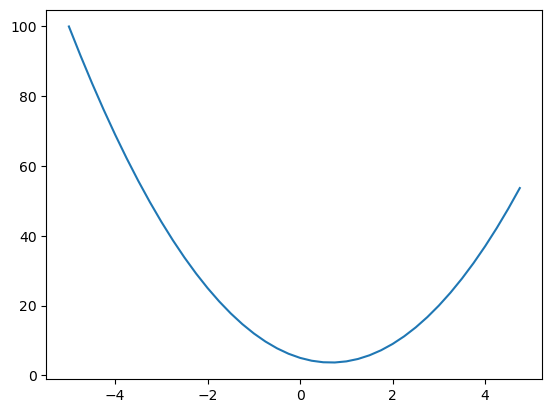

In [4]:
#1- Let's generate a set of numbers in [-5, 5)
xs = np.arange(-5, 5, 0.25)
#2- Apply f on the x values within the np array
ys = f(xs)
#3- Plot using Matplotlib
plt.plot(xs, ys)

What does taking the derivative of this function $f$ at any point $x$ tell us? It helps us answer the following questions:

- If we add a small quantity $h$ to a given $x$, how is $f$ going to respond? Is it going to increase/decrease 🤷‍♂️

- How fast will $f$ increase/decrease? In other words, what is the "rate" or the "speed" at which $f$ increase/decrease when $x$ changes 🤷‍♂️

When taking the derivative we apply the following: $\lim_{h\to 0} \frac{f(x + h) - f(x)}{h}$ and this formula is the answer to both of our questions

In [5]:
h = 0.001 #relatively small "h"
x = 3.0
(f(x + h) - f(x)) / h

14.00300000000243

In [6]:
h = 0.000000001 #an even smaller "h"
x = 3.0
(f(x + h) - f(x)) / h

14.000001158365194

This is a numerical approximation of the rate of change (slope) of $f$ when $x = 3$.  It tells us that at when $x = 3$, the function $f$ is "increasing" at a rate of $14$.

If $h$ could get infinitely small, our expression would converge to the exact value of the slope of the line tangent to the curve at $x = 3$, which is $14$.

Let's now consider a function with multiple (3) inputs.

In [7]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c

The function ($ab + c$) can also be represented using the following expression graph:

![Expression graph](./images/img-1.jpg)

It has $3$ inputs ($a$, $b$, and $c$), and $1$ output ($d$).

In [8]:
print(d)

4.0


Again, if we take the derivative of this expression with respect to one of its input variable, what would that tell us? 🤔

It would tell us **how the output $d$ would respond** (increase/decrease) and **how fast**... if one of the inputs were to **change**.

Let's illustrate this by considering input $a$. What happens if we take the derivative of the expression with respect to $a$. In other words, if $a$ were to change a little bit, how would $d$ change, and by how much?

In [9]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h # 'a' changes a little bit
d2 = a*b + c

print('d1:', d1)
print('d2:', d2)
print('slope (or rate of change):', (d2 - d1) / h)

d1: 4.0
d2: 3.999699999999999
slope (or rate of change): -3.000000000010772


See? When I increase $a$ a tiny bit, $(ab)$ becomes more negative; and when added to $c$ it results in a smaller value.

So by increasing $a$, I caused  the output $d$ to **decrease**. That's why $d_{2}$ is **smaller** than $d_{1}$, and the rate of this change (this decrease) was: $3$.

The result we got was a numerical approximation. But we can get to an exact answer using a little bit of calculus:

$\frac{\partial}{\partial a}(ab + c) = b$ and in our case $b$ is $-3$

**Experiment 🧪: How would $d$ respond if you changed $b$ or $c$?**

## Can we talk about Neural networks now?  🤷

Hummm, no ¯\\\_(ツ)\_/¯ 

But we are getting there. Slowly. 

But, I would like us to keep in mind that... neural networks are also mathematical expressions like the last expression we looked at. It's going to come handy.

What is going to happen now instead is that we are going to write a core object of Micrograd: the `Value` class.

`Value` is a wrapper class. Its job to wrap a Python numeric value. In addition, a `Value` object has the following capabilities:

1. **It maintains pointers to the `Value` objects that were used to obtain it**. For instance, if we multiply a `Value` object `a` with another `Value` object `b` ... and obtain a new `Value` object `c`, the `Value` object `c` will contain pointers to `Value` objects `a` and `b`. In fact, `a` and `b` will be called *children* of `c`.

2. **It records the type of the operation that was used to obtain it**. If we consider the same `Value` objects `a`, `b` and `c`. `Value` object `c` will contain an information that will let us know that `c` was obtained by the addition of `a` and `b`. Here is an image to illustrate the two previous points:

![illustration](./images/img-2.jpg)

In [33]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0 #the derivative of the ouptut with respect to this Value.
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), _op='tanh')
        return out
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b ; e.label = 'e'
d = e + c ; d.label= 'd'

f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data = -8.0)

With the above implementation, we can perform additions and multiplications on `Value` objects and each object resutlting from either operations maintains a pointer to the `Value` objects that were used to create it. Those `Value` objects are accessible through the `prev` attribute, which is a set of tuples (i.e. pairs).

Using this simple data structure, we can compose mathematical expressions and have the expression graphs built in the background. That's pretty cool.

Andrej pushed it a step further by providing the following code snippet. Its job is to help us visualize the expression graphs we are building out using the the **graphiz**. Each node in the expression graph contains:

- A **label**: The name of the node
- A **data**: The numerical value of node
- A **gradient**: The derivative of the output with respect to the node

In [34]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

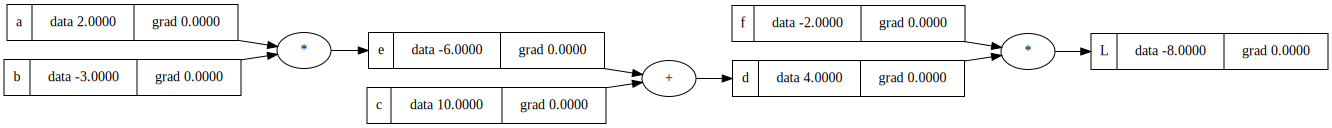

In [35]:
draw_dot(L)

So far, we are able to compute the forward pass of a mathematical expression. What are going to do now is important because we'll try to run backpropagation. We'll start at the end, and compute the gradient. We'll compute the partial derivative of `L`, the output, with respect to each node in the expression graph.

# Manual backpropagation example

Using the expression graph generated earlier, we will compute backpropagation **manually**.

We start with **node `L`**.

Question: **What is the derivative of Node `L` with respect to itself?**

$\frac{\partial L}{\partial L} = 1$

It is **1**. So,

In [36]:
L.grad = 1.0

We continue with **node `d`** and **node `f`**.

$\longrightarrow$ Question: **What is the derivative of Node `L` with respect to Node `d`?** In other words, *how does the value in node `L` reacts when the one in node `d` changes a little bit?*

$\frac{\partial L}{\partial d} = \frac{\partial}{\partial d}(d \times f) = f$

`grad` in node `d` is the value in node `f`. It implies that if we change the value in Node `d`, we expect the value in Node `L` to **decrease** at a rate of `2.0`.

$\longrightarrow$ Question: **What is the derivative of Node `L` with respect to Node `f`?** In other words, *how does the value in node `L` reacts when the one in node `f` changes a little bit?*

$\frac{\partial L}{\partial f} = \frac{\partial}{\partial f}(d \times f) = d$

`grad` in node `f` is the value in node `d`. It means that if we change the value Node `f`, we expect the value in Node `L` to **increase** at a rate of `4.0`.

so,

In [37]:
d.grad = -2
f.grad = 4.0

We continue with **node `c`** and **node `e`**

$\longrightarrow$ **Question: What is the derivative of Node `L` with respect to Node `c`?** In other words, *how does the value in node `L` reacts when the one in node `c` changes a little bit?*

$\frac{\partial L}{\partial c} = \frac{\partial L}{\partial d} \times \frac{\partial d}{\partial c} = \frac{\partial L}{\partial d} \times \frac{\partial}{\partial c}(c + e) = \frac{\partial L}{\partial d} \times 1 = \frac{\partial L}{\partial d}$

Remember, we computed $\frac{\partial L}{\partial d}$ earlier. It is currently stored in `d.grad`.

$\longrightarrow$ **Question: What is the derivative of Node `L` with respect to Node `e`?** In other words, *how does the value in node `L` reacts when the one in node `e` changes a little bit?*

$\frac{\partial L}{\partial e} = \frac{\partial L}{\partial d} \times \frac{\partial d}{\partial e} = \frac{\partial L}{\partial d} \times \frac{\partial}{\partial e}(c + e) = \frac{\partial L}{\partial d} \times 1 = \frac{\partial L}{\partial d}$

Again, the term $\frac{\partial L}{\partial d}$ repeats.

In [38]:
c.grad = -2.0
e.grad = -2.0

Please notice how `d.grad` was forwarded (or routed) to both nodes `c` and `e`. In other words, the `grad` in Node `d` was forwarded to all of its children.

Again notice, both $\frac{\partial d}{\partial c}$ and $\frac{\partial d}{\partial e}$ are called "**local**" derivatives. They only give us info on this part of the graph:

![Portion](./images/img-3.jpg)

They tell us how changing the values in `c` and `e` by a tiny amount influences the value in `d`. This portion does not know anything about the rest of graph it is embedded in.

If you paid close attention so far, you'd notice that we computed $\frac{\partial L}{\partial c}$ and $\frac{\partial L}{\partial e}$ using the chain rule. 

But, we can say that we obtained $\frac{\partial L}{\partial c}$ and $\frac{\partial L}{\partial e}$ by multiplying "local" gradients with $\frac{\partial L}{\partial d}$ which is the grad value of the node **parent** to Node `c` and Node `e`. Can you see? It is an important observation.🤔

Let's finish with **node `a`** and **node `b`**

$\longrightarrow$ **Question: What is the derivative of Node `L` with respect to Node `a`?** In other words, how does the value in Node `L` reacts when the one in Node `a` changes a little bit?

We can do it two ways. Using the following formula:

$\frac{\partial L}{\partial a} = \frac{\partial L}{\partial d} \times \frac{\partial d}{\partial e} \times \frac{\partial e}{\partial a}$

Or, we can leverage the observation we made earlier. We can obtain $\frac{\partial L}{\partial a}$ by multiplying local derivative $\frac{\partial e}{\partial a}$ with $\frac{\partial L}{\partial e}$, which is the gradient of the node parent to `a` (Node `e`)... which we computed *already* and is stored in `e.grad`.

$\frac{\partial L}{\partial a} = \frac{\partial L}{\partial e} \times \frac{\partial e}{\partial a}$

$\longrightarrow$ **Question: What is the derivative of Node `L` with respect to Node `b`?** In other words, how does the value in Node `L` reacts when the one in Node `b` changes a little bit?

Here again, we can use our observation and write:

$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial e} \times \frac{\partial e}{\partial b}$

In [39]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

***

With all the gradient computed, redrawing our graph now gives the following:

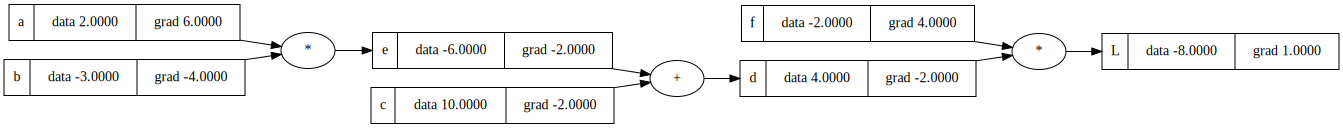

In [40]:
draw_dot(L)

Okay, we computed the gradient (partial derivatives) of the output with respect to each node in the expression graph. But why is it useful? 🤔

Consider this question: **Can we nudge our inputs to try to make the value in node `L` go up?**

If we want the value in Node `L` to go up (become less negative)... we need to nudge the inputs (leaf  nodes) of our graph a *tiny amount* in the **direction of the gradient**.

Think about it of a second, it makes sense. This is how I personally approached it. I asked myself the following question:

- What is the meaning of a gradient?

The gradient of a multi-variable function, is a **vector**. It represents the direction one should choose to reach a local/global maximum **fastest**. It shows the direction of greatest increase.

I imagine myself standing at a random position (black dot) on a hill:

![Kassi on a hill](./images/img-4.jpg)

And asking myself, **which direction should I choose to reach the top faster?**. I have a lot of options (red arrows). They will surely make me get closer to the top. But will I get there faster than someone who chose to move in the direction of the green arrow? NO!

Depending on my current position, computing the gradient helps me determine the direction of fastest increase (the green vector). So if I update my current position using the coordinates of the gradient vector, **my new position would not be closer to the top, but I would have got there the fastest**!

Coming back to our expression graph...

The `data` values of the input Nodes of the expression graph represents my current position, and their respective `grad` values represent the coordinate of gradient vector (the green vector). So, if I update my current position using the coordinates of gradient, I should effectively **increase** the value in Node `L`.

Here is how it goes in practice:

In [41]:
#SMALL step from our current position  in the direction of the gradient
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

#We recompute the forward pass (that is new value of L)
e = a * b
d = e + c
L = d * f

#display it
print(L.data)


-7.286496


See!?

The value in Node `L` increased. It became less negative.

What we went through, is one example of an optimization step that will perform in the future. Extremely useful and powerfull in training neural networks. We are getting there, so buckle up! 🚀

Oof! 😮‍💨 

Let's rest a little bit, and digest what we learned

![Rest GIF](./images/img-gif-1.gif)

# Manual backpropagation with a neuron

In this section, we explore another example of backpropagation, but with a neuron this time. This example a little complex, but a lot more useful than the previous.

We will build a 2-inputs neuron. Essentially, we'll try to build a neuron like the following:

![2 input neuron](./images/img-5.jpg)

`b` is the **bias**. It tells us how hard it is for this neuron to fire. A high bias means "hard to trigger" whereas a low bias means "very easy to trigger".

For this example, we'll be using `tanh` as our activation function. It looks like this:

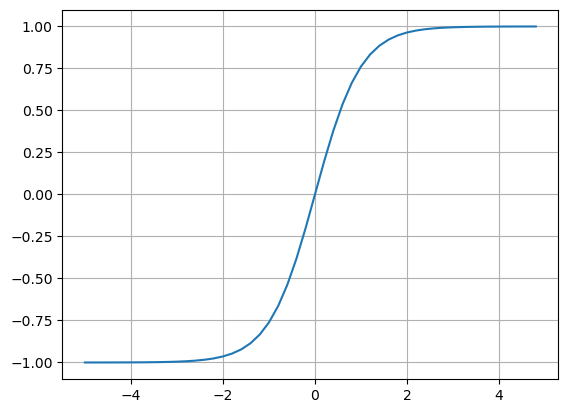

In [42]:
#Numpy provides a definition for "tanh"
import numpy as np
plt.plot(np.arange(-5 ,5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

It looks a bit like the `sigmoid` function, don't you think? I do 🤷

Let's now build our 2-input neuron. To do that, we will compose the mathematical expression describing this neuron, using the `Value` object. Here is how it goes:

In [45]:
#--- Inputs 1 & 2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#---- Weights 1 & 2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#--- bias
b = Value(6.7, label='b')

#net sum = x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# 'n' goes through activation function
#giving the final result.
o = n.tanh(); o.label='o'

Let's graph the above expression using the `draw_dot` helper:

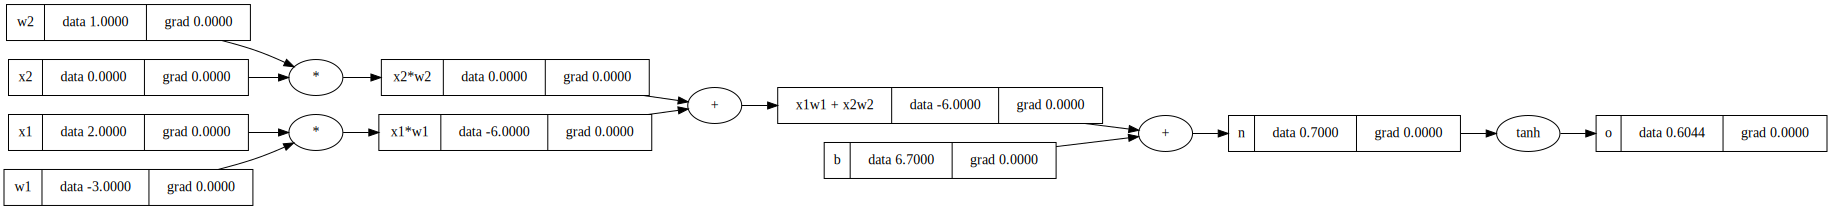

In [46]:
draw_dot(o)